In [1]:
import SimpleITK as sitk
import json
import numpy as np
import matplotlib.pyplot as plt
import skfmm
import scipy.ndimage.morphology

In [2]:
# Load Mask as nii file.
img = sitk.ReadImage('data/TestMask.nii')
print(img.GetSize())
print(img.GetSpacing())
arr = sitk.GetArrayFromImage(img)
arr = np.transpose(arr, [2, 1, 0])
print(arr.shape)

(380, 285, 260)
(1.0, 1.0, 1.0)
(380, 285, 260)


In [3]:
# Load landmarks.
points = []
with open('data/circles.ano.json') as json_file:
    data = json.load(json_file)
    ano = data['annotations'][0]
    for p in ano['points']:
        points.append(p['coords_vox'])
        print(p['coords_vox'])

[201, 176, 113]
[205, 240, 150]
[234, 105, 113]


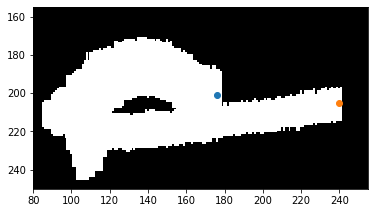

In [4]:
fig, ax = plt.subplots()
ax.imshow(np.max(arr, axis=2), cmap='gray')
ax.set_ylim([250, 155])
ax.set_xlim([80, 255])
ax.scatter(points[0][1], points[0][0])
ax.scatter(points[1][1], points[1][0])
plt.gca().set_aspect(1)
plt.show()

In [5]:
# Define boundaries.
mask = (arr == 0)

# Zero level of phi define wave front contour.
phi = -1 * np.ones_like(arr)
# Point source.
phi[int(points[0][0]), int(points[0][1]), int(points[0][2])] = 1.0
# Define boundaries (outside V=0).
phi  = np.ma.MaskedArray(phi, mask)

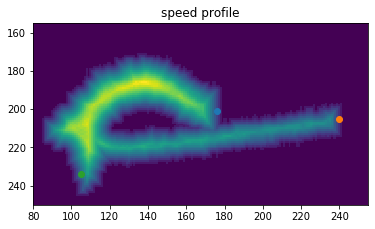

In [6]:
# Euclidean distance transform.
edt = scipy.ndimage.morphology.distance_transform_edt(~mask)

fig, ax = plt.subplots()
ax.imshow(np.max(edt, axis=2))
ax.scatter(points[0][1], points[0][0])
ax.scatter(points[1][1], points[1][0])
ax.scatter(points[2][1], points[2][0])
ax.set_ylim([250, 155])
ax.set_xlim([80, 255])
ax.set_title('speed profile')
plt.gca().set_aspect(1)
plt.show()

In [7]:
# Scalar field with normal velocities of the wave front.
# Uniform velocity field.
V = np.ones_like(mask)
# Velocity derived from euclidean distance.
V = edt

In [8]:
# Calculate distance and travel time for each point.
d = skfmm.distance(phi, dx=1.0)
T = skfmm.travel_time(phi, V, dx=1.0)

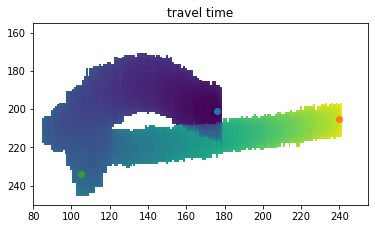

In [9]:
fig, ax = plt.subplots()
ax.imshow(np.mean(T, axis=2))
ax.scatter(points[0][1], points[0][0])
ax.scatter(points[1][1], points[1][0])
ax.scatter(points[2][1], points[2][0])
ax.set_title('travel time')
ax.set_ylim([250, 155])
ax.set_xlim([80, 255])
plt.gca().set_aspect(1)
plt.show()

In [10]:
# Calculate gradient of T(x) with Sobel filter.
gradTx = scipy.ndimage.sobel(T,axis=0)
gradTy = scipy.ndimage.sobel(T,axis=1)
gradTz = scipy.ndimage.sobel(T,axis=2)

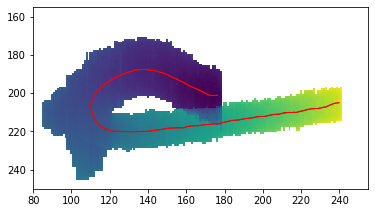

In [12]:
# Set start point.
p_start = np.array(points[1])

# Set relative step size.
step = 0.5

fig, ax = plt.subplots()
ax.imshow(np.mean(T, axis=2))

# Integrate gradient field.
p_hist = [p_start]
p = p_start
for i in range(500):
    grad = np.array([gradTx[int(p[0]), int(p[1]), int(p[2])],
                     gradTy[int(p[0]), int(p[1]), int(p[2])],
                     gradTz[int(p[0]), int(p[1]), int(p[2])]])
    
    delta= -grad/np.linalg.norm(grad)*step
    ax.arrow(p[1], p[0], delta[1], delta[0], color='red')
    p_new = p + delta
    p_hist.append(p_new)
    p = p_new

ax.set_ylim([250, 155])
ax.set_xlim([80, 255])
plt.gca().set_aspect(1)
plt.show()